## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

1. **Critical Care Protocols:** "What is the protocol for managing sepsis in a critical care unit?"

2. **General Surgery:** "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

3. **Dermatology:** "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

4. **Neurology:** "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [ ]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              ragas==0.3.0 \
              datasets==4.0.0 \
              evaluate==0.4.5 \
              langchain_openai==0.3.30 \
              pypdf \
              langchain_huggingface

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [ ]:
# Import core libraries
import os                                                                       # Interact with the operating system (e.g., set environment variables)
import json                                                                     # Read/write JSON data

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader                            # Load and extract text from PDF files
from openai import OpenAI                                                       # Access OpenAI's models and services

# Import libraries for processing dataframes and text
import tiktoken                                                                 # Tokenizer used for counting and splitting text for models
import pandas as pd                                                             # Load, manipulate, and analyze tabular data

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter              # Break text into overlapping chunks for processing
from langchain.embeddings.openai import OpenAIEmbeddings                        # Create vector embeddings using OpenAI's models  # type: ignore
from langchain.vectorstores import Chroma                                       # Store and search vector embeddings using Chroma DB  # type: ignore

# Import components to run evaluation on RAG pipeline outputs
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextPrecisionWithoutReference,
)
from datasets import Dataset                                                    # Used to structure the input (questions, answers, contexts etc.) in tabular format
from langchain_openai import ChatOpenAI

In [ ]:
import json
import os

# Assuming your config file is named 'config.json'
config_file_path = '/content/config.json'


In [ ]:
# Load the JSON file and extract values
file_name = '/content/config.json'                                                       # Name of the configuration file
with open(file_name, 'r') as file:                                              # Open the config file in read mode
    config = json.load(file)                                                    # Load the JSON content as a dictionary
    API_KEY = config.get("OPENAI_API_KEY")                                             # Extract the API key from the config
    OPENAI_API_BASE = config.get("OPENAI_API_BASE")                             # Extract the OpenAI base URL from the config

# Store API credentials in environment variables
os.environ['OPENAI_API_KEY'] = API_KEY                                          # Set API key as environment variable
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE                                 # Set API base URL as environment variable

# Initialize OpenAI client
client = OpenAI()

## Question Answering using LLM

#### Downloading and Loading the model

In [ ]:
# Define a function to get a response
def response(user_prompt, max_tokens=500, temperature=0.3, top_p=0.95):
    # Create a chat completion using the OpenAI client
    completion = client.chat.completions.create(
        model="gpt-4o-mini",                                                     # Specify the model to use
        messages=[
            {"role": "user", "content": user_prompt}                            # User prompt is the input/query to respond to
        ],
        max_tokens=max_tokens,                                                  # Max number of tokens to generate in the response
        temperature=temperature,                                                # Controls randomness in output
        top_p=top_p                                                             # Controls diversity via nucleus sampling
    )
    return completion.choices[0].message.content

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
# Define the question
question_1 = "What is the protocol for managing sepsis in a critical care unit?"
base_prompt_response_1 = response(question_1)
base_prompt_response_1

"Managing sepsis in a critical care unit involves a systematic approach that includes early recognition, prompt intervention, and ongoing monitoring. Here’s a general protocol for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Identify Symptoms:** Look for signs of infection (fever, chills, tachycardia, tachypnea) and signs of organ dysfunction (altered mental status, hypotension, oliguria).\n   - **Use Screening Tools:** Utilize sepsis screening tools or protocols to identify patients at risk.\n\n### 2. **Initial Assessment**\n   - **Vital Signs Monitoring:** Continuous monitoring of heart rate, blood pressure, respiratory rate, and temperature.\n   - **Laboratory Tests:** Obtain blood cultures, complete blood count, lactate levels, renal function tests, and liver function tests.\n   - **Imaging Studies:** Consider imaging to identify the source of infection if clinically indicated.\n\n### 3. **Sepsis Bundle (within the first hour)**\n   - **Administer IV Fluids:** Start wit

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
question_2 = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"
base_prompt_response_2 = response(question_2)
base_prompt_response_2

"Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then moves to the lower right abdomen.\n2. **Nausea and Vomiting**: Often follows the onset of abdominal pain.\n3. **Loss of Appetite**: A decrease in desire to eat.\n4. **Fever**: Mild fever may be present.\n5. **Constipation or Diarrhea**: Some patients may experience changes in bowel habits.\n6. **Bloating**: A feeling of fullness or swelling in the abdomen.\n\nAppendicitis is generally not treatable with medication alone. The standard treatment for appendicitis is surgical removal of the appendix, a procedure known as **appendectomy**. This can be performed as:\n\n- **Open Appendectomy**: A larger incision is made in the lower right abdomen.\n- **Laparoscopic Appendectomy**: A minimally invasive procedure using small incisions and a camera.\n\nIn some cases, if the appendicitis is diagnosed early and is uncomplicated, antibiotics may be used as an initial treatment, but surgery

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
question_3 = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"
base_prompt_response_3 = response(question_3)
base_prompt_response_3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp and can be distressing. Here are some effective treatments and solutions, as well as potential causes for this condition:\n\n### Possible Causes:\n1. **Autoimmune Response**: The body’s immune system mistakenly attacks hair follicles, leading to hair loss.\n2. **Genetics**: A family history of alopecia or other autoimmune conditions may increase susceptibility.\n3. **Stress**: Physical or emotional stress can trigger hair loss in some individuals.\n4. **Hormonal Changes**: Hormonal fluctuations, such as those occurring during pregnancy or menopause, can contribute.\n5. **Nutritional Deficiencies**: Lack of essential nutrients, such as iron, zinc, or vitamin D, may play a role.\n6. **Infections**: Fungal infections of the scalp, such as tinea capitis, can lead to hair loss.\n7. **Medical Conditions**: Other autoimmune diseases, thyroid disorders, or skin conditions can also 

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
question_4 = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"
base_prompt_response_4 = response(question_4)
base_prompt_response_4

"Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the individual's overall health. Here are some commonly recommended treatments and approaches:\n\n1. **Emergency Care**: \n   - Immediate medical attention is crucial. This may involve stabilizing the patient, ensuring adequate oxygenation, and managing intracranial pressure.\n\n2. **Medication**:\n   - **Analgesics**: To manage pain.\n   - **Anticonvulsants**: To prevent seizures, which can occur after a brain injury.\n   - **Diuretics**: To reduce swelling in the brain.\n   - **Corticosteroids**: To decrease inflammation in certain cases.\n\n3. **Surgery**:\n   - In cases of severe injury, surgery may be necessary to remove blood clots (hematomas), repair skull fractures, or relieve pressure on the brain.\n\n4. **Rehabilitation**:\n   - **Physical Therapy**: To improv

In [ ]:
# Create the DataFrame
result_df = pd.DataFrame({
    "questions": [question_1, question_2, question_3, question_4],
    "base_prompt_responses": [base_prompt_response_1, base_prompt_response_2, base_prompt_response_3, base_prompt_response_4]})

# Display the DataFrame
result_df.head()

,questions,base_prompt_responses
0,What is the protocol for managing sepsis in a ...,Managing sepsis in a critical care unit involv...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ..."
3,What treatments are recommended for a person w...,Treatment for a person who has sustained a phy...


## Question Answering using LLM with Prompt Engineering

**Note:**
Attempting to make LLM responses faster, cheaper, and more reliable with a few small tweaks:
1. Using a system prompt and a tight template.
Giving the model clear constraints up front (concise, bullet points, cite guidelines). This should reduce tokens and improve consistency.
2. Prefering the newer Responses API (lower overhead, more features).

In [ ]:
from openai import OpenAI, RateLimitError, APIStatusError
import uuid, time

PREFERRED_MODELS = ["gpt-5-mini", "o4-mini", "gpt-4o"]  # adjust order for your account

SYSTEM = """You are a critical-care assistant.
Answer concisely in bullet points, structured by time window (0–1h, 1–6h, etc.),
and include guideline sources if mentioned in the prompt. Do not give individualized medical advice."""

client = OpenAI(timeout=30)  # tweak if you truly see timeouts, e.g., 60

def respond(prompt, max_output_tokens=350, temperature=0.2, top_p=0.95):
    last_err = None
    for model in PREFERRED_MODELS:
        try:
            r = client.with_options(timeout=30).responses.create(
                model=model,
                input=[{"role":"system","content":SYSTEM},
                       {"role":"user","content":prompt}],
                max_output_tokens=max_output_tokens,
                temperature=temperature,
                top_p=top_p,
                extra_headers={"Idempotency-Key": str(uuid.uuid4())}
            )
            return r.output_text, model
        except (RateLimitError, APIStatusError) as e:
            last_err = e
            # brief backoff before trying next model
            time.sleep(1.2)
            continue
    # If all fail, re-raise the last error
    raise last_err


### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
prompt_1 = (
    "Outline the protocol for managing adult sepsis in a critical care unit. "
    "Structure by time window (0–1h, 1–6h, 6–24h). "
    "Include: sepsis recognition criteria, cultures, early antibiotics, fluid resuscitation (type & volumes), "
    "vasopressors (first-line & targets), lactate monitoring, source control, ventilation/oxygenation targets, "
    "steroids criteria, glucose control, and when to escalate. ~200 words."
)

answer1 = respond(prompt_1)
print(answer1)

('### 0–1 Hour\n- **Sepsis Recognition:**\n  - Use qSOFA: altered mentation, respiratory rate ≥22/min, systolic BP ≤100 mmHg.\n  - Confirm with SOFA score increase ≥2 points.\n- **Cultures:**\n  - Obtain blood cultures before antibiotics if no significant delay.\n- **Antibiotics:**\n  - Administer broad-spectrum antibiotics within 1 hour.\n- **Fluid Resuscitation:**\n  - Initiate with 30 mL/kg of crystalloid (e.g., lactated Ringer’s or normal saline).\n- **Lactate Monitoring:**\n  - Measure lactate; remeasure if initial lactate >2 mmol/L.\n\n### 1–6 Hours\n- **Vasopressors:**\n  - Start norepinephrine if MAP <65 mmHg after fluids.\n- **Lactate Monitoring:**\n  - Monitor trends to guide resuscitation.\n- **Source Control:**\n  - Identify and control infection source (e.g., drainage, surgery).\n- **Ventilation/Oxygenation:**\n  - Target SpO2 ≥94%.\n\n### 6–24 Hours\n- **Steroids:**\n  - Consider hydrocortisone if hemodynamics remain unstable.\n- **Glucose Control:**\n  - Maintain blood g

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
prompt_2 = (
    "Summarize the standard clinical protocol for suspected acute appendicitis in adults. "
    "Include: (1) common presenting symptoms and signs; (2) role of imaging/lab tests for diagnosis; "
    "(3) whether medical therapy (e.g., antibiotics) alone is sufficient and in which cases; "
    "(4) when surgery is necessary, and describe the standard surgical approach (open vs laparoscopic appendectomy); "
    "(5) key post-operative care steps. Use bullet points, ~200 words."
)
answer2 = respond(prompt_2)
print(answer2)


('**0–1h: Initial Assessment**\n\n- **Symptoms and Signs:**\n  - Right lower quadrant abdominal pain\n  - Nausea and vomiting\n  - Anorexia\n  - Fever\n  - Rebound tenderness and guarding\n\n**1–6h: Diagnostic Evaluation**\n\n- **Imaging:**\n  - Ultrasound: First-line in certain populations (e.g., pregnant women)\n  - CT Scan: Preferred for adults, high sensitivity and specificity\n\n- **Lab Tests:**\n  - Complete blood count (CBC): Leukocytosis\n  - C-reactive protein (CRP): Elevated levels\n\n**6–12h: Treatment Decision**\n\n- **Medical Therapy:**\n  - Antibiotics alone may be considered in uncomplicated cases\n  - Not standard; typically reserved for non-surgical candidates\n\n- **Surgery Indications:**\n  - Confirmed diagnosis of appendicitis\n  - Complicated appendicitis (e.g., perforation, abscess)\n\n**12–24h: Surgical Approach**\n\n- **Appendectomy:**\n  - Laparoscopic: Preferred due to faster recovery, less pain\n  - Open: Considered in specific cases (e.g., extensive infectio

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
prompt_3 = (
    "Outline the causes, diagnosis, and management of sudden patchy hair loss on the scalp "
    "(commonly seen as alopecia areata). "
    "Structure the answer in sections: (1) common causes and differential diagnoses; "
    "(2) recommended diagnostic evaluations; "
    "(3) first-line and second-line treatment options (topical, oral, injections, systemic therapies); "
    "(4) supportive measures such as lifestyle or cosmetic options. "
    "Use concise bullet points, ~250 words."
)
answer3 = respond(prompt_3)
print(answer3)

('### Common Causes and Differential Diagnoses\n\n- **Alopecia Areata:**\n  - Autoimmune condition targeting hair follicles.\n  - Often associated with other autoimmune disorders.\n\n- **Differential Diagnoses:**\n  - **Tinea Capitis:** Fungal infection, often with scaling.\n  - **Trichotillomania:** Hair-pulling disorder.\n  - **Telogen Effluvium:** Stress-related hair shedding.\n  - **Androgenetic Alopecia:** Pattern hair loss.\n\n### Recommended Diagnostic Evaluations\n\n- **Clinical Examination:**\n  - Look for exclamation mark hairs, smooth patches.\n  \n- **Dermatological Evaluation:**\n  - Dermoscopy to assess hair follicle health.\n\n- **Laboratory Tests:**\n  - Thyroid function tests.\n  - Autoimmune panel if other symptoms present.\n\n- **Scalp Biopsy:**\n  - Consider if diagnosis is uncertain.\n\n### First-Line and Second-Line Treatment Options\n\n- **First-Line Treatments:**\n  - **Topical Corticosteroids:** Reduce inflammation.\n  - **Intralesional Corticosteroid Injection

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
prompt_4 = (
    "Summarize the general management of traumatic brain injury (TBI) in adults. "
    "Divide into acute phase (emergency/ICU) vs long-term rehabilitation. "
    "Include: initial stabilization (airway, breathing, circulation, ICP control, imaging), "
    "surgical interventions (e.g., decompression, hematoma evacuation), "
    "medical management (osmotic therapy, blood pressure targets, seizure prophylaxis), "
    "monitoring and supportive care, "
    "rehabilitation strategies (physiotherapy, occupational therapy, cognitive rehab), "
    "and prognosis factors. Use a structured outline format, ~300 words."
)
answer4 = respond(prompt_4)
print(answer4)

('## Acute Phase (Emergency/ICU)\n\n### Initial Stabilization (0–1h)\n- **Airway, Breathing, Circulation (ABC):**\n  - Ensure airway patency; consider intubation if GCS ≤ 8.\n  - Maintain adequate oxygenation and ventilation.\n  - Stabilize circulation; monitor blood pressure and heart rate.\n\n- **Intracranial Pressure (ICP) Control:**\n  - Elevate head of bed to 30 degrees.\n  - Administer osmotic therapy (e.g., mannitol or hypertonic saline) if needed.\n\n- **Imaging:**\n  - Perform CT scan to assess for hematomas, contusions, or skull fractures.\n\n### Surgical Interventions (1–6h)\n- **Decompression:**\n  - Consider decompressive craniectomy for refractory ICP.\n  \n- **Hematoma Evacuation:**\n  - Evacuate significant epidural or subdural hematomas.\n\n### Medical Management (1–24h)\n- **Osmotic Therapy:**\n  - Continue mannitol or hypertonic saline as needed for ICP control.\n\n- **Blood Pressure Targets:**\n  - Maintain systolic BP > 100 mmHg (ages 50-69) or > 110 mmHg (ages 15-

In [ ]:
# Create the DataFrame
result_df2 = pd.DataFrame({
    "prompts": [prompt_1, prompt_2, prompt_3, prompt_4],
    "base_prompt_responses": [answer1, answer2, answer3, answer4]})

# Display the DataFrame
result_df2.head()

,prompts,base_prompt_responses
0,Outline the protocol for managing adult sepsis...,(### 0–1 Hour\n- **Sepsis Recognition:**\n - ...
1,Summarize the standard clinical protocol for s...,(**0–1h: Initial Assessment**\n\n- **Symptoms ...
2,"Outline the causes, diagnosis, and management ...",(### Common Causes and Differential Diagnoses\...
3,Summarize the general management of traumatic ...,(## Acute Phase (Emergency/ICU)\n\n### Initial...


## Data Preparation for RAG

### Loading the Data

In [ ]:
# 0) Prereqs (run in a cell, once):
# pip install -q "langchain>=0.2.0" langchain-community langchain-text-splitters \
#               langchain-openai langchain-huggingface chromadb pypdf python-dotenv \
#               sentence-transformers tiktoken tenacity

import os, sys, time, json
from typing import List
from dotenv import load_dotenv
load_dotenv()  # expects OPENAI_API_KEY in your .env (optional)

# LangChain loaders/splitters
from langchain_community.document_loaders import PyPDFLoader  # try PyMuPDFLoader if layout matters
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Embeddings (OpenAI + HuggingFace)
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Vector store
from langchain_community.vectorstores import Chroma

# LLM client (OpenAI)
from openai import OpenAI
client = OpenAI()  # uses env vars

# Optional: retry helpers
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import RateLimitError as OpenAIRateLimitError

# ------------------------------
# 1) Load your PDF (Data Overview)
# ------------------------------
pdf_path = "/content/medical_diagnosis_manual.pdf"
docs = PyPDFLoader(pdf_path).load()

print(f"Loaded {len(docs)} pages.")
print("Sample metadata:", docs[0].metadata)
print("First 500 chars of page 1:\n", docs[0].page_content[:500])

# ------------------------------
# 2) Chunk the docs
# ------------------------------
splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,       # keep < 1k chars to fit in context better
    chunk_overlap=150,
    separators=["\n\n", "\n", " ", ""]
)
chunks = splitter.split_documents(docs)
print(f"Total chunks: {len(chunks)}")

# ------------------------------
# 3) Embeddings with fallback
# ------------------------------
persist_dir = "./chroma_med_manual"

def get_openai_embeddings():
    # Use a smaller, cheaper model; great for many RAG cases
    return OpenAIEmbeddings(model="text-embedding-3-small")

def get_local_embeddings():
    # Local free model; smaller but solid for RAG
    # (If you want stronger: "sentence-transformers/all-MiniLM-L12-v2" or "all-mpnet-base-v2")
    return HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

def try_build_chroma_with(embedding_fn):
    return Chroma.from_documents(
        documents=chunks,
        embedding=embedding_fn,
        persist_directory=persist_dir,
    )

# Try OpenAI first; on quota/429, fall back to local
try:
    print("Embedding with OpenAI (text-embedding-3-small)...")
    vectordb = try_build_chroma_with(get_openai_embeddings())
except Exception as e:
    # Detect common quota/rate-limit cases
    msg = str(e)
    if "insufficient_quota" in msg or "429" in msg or "RateLimitError" in msg:
        print("OpenAI quota/rate limit hit. Falling back to local embeddings...")
        vectordb = try_build_chroma_with(get_local_embeddings())
    else:
        raise

vectordb.persist()
print("✅ Indexed & persisted at:", persist_dir)

# ------------------------------
# 4) Retriever
# ------------------------------
retriever = vectordb.as_retriever(
    search_type="mmr",                # diverse results
    search_kwargs={"k": 4, "fetch_k": 20}
)

# ------------------------------
# 5) Response function (stuffing RAG)
# ------------------------------
SYSTEM = (
    "You are a clinical reference assistant. Use only the provided context to answer. "
    "Be concise, use bullet points, and include page references from metadata when possible. "
    "This is general information, not individualized medical advice."
)

def format_context(docs):
    out = []
    for i, d in enumerate(docs, 1):
        meta = d.metadata or {}
        page = meta.get("page", "NA")
        src = meta.get("source", "")
        out.append(f"[{i}] (page {page}) {d.page_content}")
    return "\n\n".join(out)

def llm_answer(question: str, max_output_tokens=350, temperature=0.2, top_p=0.95) -> str:
    # 1) Retrieve
    ctx_docs = retriever.get_relevant_documents(question)
    context_str = format_context(ctx_docs)

    # 2) Prompt
    user_prompt = (
        f"Question: {question}\n\n"
        f"Context (use ONLY this):\n{context_str}\n\n"
        "Answer in 150–250 words. If answer not in context, say 'Not found in provided context.'"
    )

    # 3) Call LLM
    r = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": SYSTEM},
            {"role": "user", "content": user_prompt},
        ],
        max_tokens=max_output_tokens,
        temperature=temperature,
        top_p=top_p,
    )
    return r.choices[0].message.content, ctx_docs

# ------------------------------
# 6) Example query
# ------------------------------
q = "Outline early management steps for suspected sepsis per this manual."
answer, sources = llm_answer(q)
print("\n--- ANSWER ---\n", answer)
print("\n--- SOURCES ---")
for i, d in enumerate(sources, 1):
    print(f"[{i}] source={d.metadata.get('source')} page={d.metadata.get('page')}")


Loaded 4114 pages.
Sample metadata: {'producer': 'pdf-lib (https://github.com/Hopding/pdf-lib)', 'creator': 'Atop CHM to PDF Converter', 'creationdate': '2012-06-15T05:44:40+00:00', 'moddate': '2025-09-24T21:37:29+00:00', 'title': 'The Merck Manual of Diagnosis & Therapy, 19th Edition', 'source': '/content/medical_diagnosis_manual.pdf', 'total_pages': 4114, 'page': 0, 'page_label': 'i'}
First 500 chars of page 1:
 vera@southwell.org
EH7I9IQT5W
This file is meant for personal use by vera@southwell.org only.
Sharing or publishing the contents in part or full is liable for legal action.
Total chunks: 19668
Embedding with OpenAI (text-embedding-3-small)...


/tmp/ipython-input-3425374243.py:85: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()
/tmp/ipython-input-3425374243.py:116: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  ctx_docs = retriever.get_relevant_documents(question)


✅ Indexed & persisted at: ./chroma_med_manual

--- ANSWER ---
 Early management steps for suspected sepsis include:

- **Recognition of Symptoms**: Look for signs such as tachypnea, hypotension, and mental status changes (page 1298).
- **Immediate Antibiotic Administration**: Start antibiotics as soon as possible, ideally within 8 hours of presentation (page 2094).
- **Fluid Resuscitation**: Provide supportive care with intravenous fluids to address hypotension and maintain perfusion (page 2094).
- **Oxygen Support**: Administer supplemental oxygen for patients with hypoxemia (page 2094).
- **Consider ICU Admission**: Patients requiring mechanical ventilation or those with unresponsive hypotension (systolic BP < 90 mm Hg) should be considered for ICU admission (page 2094).
- **Cultures**: In neonates with suspected sepsis, initiate antibiotics after obtaining blood cultures (page 2994).

These steps are crucial for managing suspected sepsis effectively and improving patient outcomes.



## Question Answering using RAG

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [ ]:
rag1, sources = llm_answer('What is the protocol for managing sepsis in a critical care unit per this document?')
print("\n--- ANSWER ---\n", rag1)
print("\n--- SOURCES ---")
for i, d in enumerate(sources, 1):
    print(f"[{i}] source={d.metadata.get('source')} page={d.metadata.get('page')}")



--- ANSWER ---
 - **Fluid Resuscitation**: Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg (10 cm H2O) or pulmonary artery occlusion pressure (PAOP) is adequate (page 2455).
- **Oxygen Therapy**: Ensure adequate oxygenation (page 2455).
- **Antibiotics**: Start broad-spectrum antibiotics, adjusting based on culture results (page 2455).
- **Surgical Interventions**: Drain abscesses and excise necrotic tissue as necessary (page 2455).
- **Blood Glucose Management**: Normalize blood glucose levels (page 2455).
- **Corticosteroids**: Administer replacement-dose corticosteroids (page 2455).
- **Monitoring**: Frequent monitoring of systemic pressure, central venous pressure (CVP), pulmonary artery occlusion pressure (PAOP), pulse oximetry, arterial blood gases (ABGs), blood glucose, lactate, electrolyte levels, renal function, and urine output is essential (page 2455).
- **ICU Care**: Patients with septic shock should be treated in an Intensive Care Unit (I

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [ ]:
rag2, sources = llm_answer('Per this document, what are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?')
print("\n--- ANSWER ---\n", rag2)
print("\n--- SOURCES ---")
for i, d in enumerate(sources, 1):
    print(f"[{i}] source={d.metadata.get('source')} page={d.metadata.get('page')}")


--- ANSWER ---
 **Common Symptoms of Appendicitis (Page 172):**
- Abdominal pain
- Anorexia
- Abdominal tenderness

**Treatment Options:**
- **Surgical Removal:** Appendicitis is primarily treated through surgical removal of the appendix, known as an appendectomy.
- **Non-Surgical Treatment:** About 80% of patients can be treated successfully without surgery using:
  - Bed rest
  - NPO (nothing by mouth)
  - IV fluids
  - IV antibiotics (e.g., ceftazidime and metronidazole)
  - Percutaneous drainage for abscesses may be considered if symptoms improve.

**Indications for Surgery (Page 252):**
- Immediate surgery is required for:
  - Free perforation
  - General peritonitis
  - Severe symptoms not responding to nonsurgical treatment within 48 hours
  - Increasing pain, tenderness, and fever

In summary, while some cases of appendicitis can be managed without surgery, surgical intervention is often necessary, especially in more severe cases.

--- SOURCES ---
[1] source=/content/medical_d

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [ ]:
rag3, sources = llm_answer('Per this document, what are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?')
print("\n--- ANSWER ---\n", rag3)
print("\n--- SOURCES ---")
for i, d in enumerate(sources, 1):
    print(f"[{i}] source={d.metadata.get('source')} page={d.metadata.get('page')}")


--- ANSWER ---
 **Effective Treatments for Sudden Patchy Hair Loss:**
- **Alopecia Areata Treatments:**
  - Topical corticosteroids
  - Intralesional corticosteroids (e.g., triamcinolone acetonide)
  - Systemic corticosteroids (for severe cases)
  - Topical minoxidil
  - Topical anthralin
  - Topical immunotherapy (e.g., diphencyprone, squaric acid dibutylester)
  - Psoralen plus ultraviolet A (PUVA) therapy (page 858)

- **Traction Alopecia:**
  - Elimination of physical traction or stress to the scalp (page 858)

- **Tinea Capitis:**
  - Topical or oral antifungals (page 858)

**Possible Causes of Sudden Patchy Hair Loss:**
- **Underlying Disorders:**
  - Systemic illnesses (e.g., high fever, systemic lupus, endocrine disorders, nutritional deficiencies) (page 856)
- **Other Causes:**
  - Primary hair shaft abnormalities
  - Autoimmune diseases
  - Heavy metal poisoning
  - Rare dermatologic conditions (page 856)
- **Evaluation Considerations:**
  - Onset and duration of hair loss
 

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [ ]:
rag4, sources = llm_answer('Per this document, what treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?')
print("\n--- ANSWER ---\n", rag4)
print("\n--- SOURCES ---")
for i, d in enumerate(sources, 1):
    print(f"[{i}] source={d.metadata.get('source')} page={d.metadata.get('page')}")


--- ANSWER ---
 Recommended treatments for a person who has sustained a traumatic brain injury (TBI) include:

- **Initial Management**:
  - Ensure a reliable airway.
  - Maintain adequate ventilation, oxygenation, and blood pressure (page 3404).

- **Surgical Interventions**:
  - Surgery may be necessary for severe injuries to:
    - Place monitors for intracranial pressure.
    - Decompress the brain if intracranial pressure is elevated.
    - Remove intracranial hematomas (page 3404).

- **Post-Injury Care**:
  - In the first few days, focus on maintaining adequate brain perfusion and oxygenation.
  - Prevent complications associated with altered sensorium (page 3404).

- **Rehabilitation**:
  - Many patients require rehabilitation, particularly if they experience prolonged coma (exceeding 24 hours).
  - Rehabilitation should be planned early, focusing on cognitive and emotional areas (page 3412).
  - Patients with severe cognitive dysfunction may need extensive cognitive therapy, 

In [ ]:
# Create the DataFrame
result_df3 = pd.DataFrame({
    "rag_responses": [rag1, rag2, rag3, rag4]})

# Display the DataFrame
result_df3.head()

,rag_responses
0,- **Fluid Resuscitation**: Administer 0.9% nor...
1,**Common Symptoms of Appendicitis (Page 172):*...
2,**Effective Treatments for Sudden Patchy Hair ...
3,Recommended treatments for a person who has su...


## Output Evaluation

#### **Evaluation 1: Base Prompt Response Evaluation**

In [ ]:
import os, json, time, math
import pandas as pd
from typing import Dict, List
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
from openai import OpenAI, RateLimitError as OpenAIRateLimitError, APIError as OpenAIApiError

# ---------- Config ----------
PRIMARY_MODEL = "gpt-4o"
BACKUP_MODEL  = "gpt-4o-mini"
JUDGE_MAX_TOKENS = 200
TEMPERATURE = 0.0

client = OpenAI()  # uses env vars

# ---------- Judge prompts ----------
JUDGE_SYSTEM = (
    "You are a careful medical QA evaluator. Use ONLY the EVIDENCE. "
    'Return JSON: {"relevance":1-5,"groundedness":1-5,"completeness":1-5,'
    '"specificity":1-5,"safety":1-5,"notes_relevance":"","notes_groundedness":"",'
    '"notes_completeness":"","notes_specificity":"","notes_safety":"","overall":0-5}.'
)
JUDGE_USER_TEMPLATE = (
    "USER_QUESTION:\n{question}\n\n"
    "EVIDENCE:\n{evidence}\n\n"
    "ASSISTANT_ANSWER:\n{answer}\n\n"
    "Be strict. Return STRICT JSON only."
)

# ---------- Evidence caching ----------
_evidence_cache: Dict[str, str] = {}

def retrieve_evidence(question: str, k: int = 5) -> str:
    """Cache retrieval to avoid repeated vector DB calls."""
    if question in _evidence_cache:
        return _evidence_cache[question]
    docs = retriever.get_relevant_documents(question, k=k)
    lines = []
    for i, d in enumerate(docs, 1):
        page = d.metadata.get("page", "NA")
        src = d.metadata.get("source", "")
        excerpt = d.page_content.strip().replace("\n", " ")
        lines.append(f"[{i}] (page {page}) {excerpt[:1200]}")
    ev = "\n".join(lines) if lines else "NO EVIDENCE"
    _evidence_cache[question] = ev
    return ev

# ---------- Local heuristic fallback ----------
# Uses cosine similarity to approximate relevance & groundedness; fills others neutrally.
from sentence_transformers import SentenceTransformer, util
_local_model = None

def _get_local_embedder():
    global _local_model
    if _local_model is None:
        _local_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return _local_model

def local_heuristic_judge(question: str, answer: str, evidence: str) -> dict:
    """No-API fallback: cosine similarities as proxies."""
    model = _get_local_embedder()
    # Relevance: answer vs question
    rel = util.cos_sim(model.encode([answer], normalize_embeddings=True),
                       model.encode([question], normalize_embeddings=True)).item()
    # Groundedness: answer vs evidence
    grd = util.cos_sim(model.encode([answer], normalize_embeddings=True),
                       model.encode([evidence], normalize_embeddings=True)).item() if evidence != "NO EVIDENCE" else 0.0
    # Map cosine [-1,1] to [1,5]
    def to15(x):
        x = max(-1.0, min(1.0, float(x)))
        return round(1 + 4 * (x + 1) / 2, 2)
    relevance = to15(rel)
    groundedness = to15(grd)
    completeness = 3.0
    specificity  = 3.0
    safety       = 3.5
    overall = round((relevance + groundedness + completeness + specificity + safety)/5, 2)
    return {
        "relevance": relevance,
        "groundedness": groundedness,
        "completeness": completeness,
        "specificity": specificity,
        "safety": safety,
        "notes_relevance": "Local heuristic (cosine) vs question.",
        "notes_groundedness": "Local heuristic (cosine) vs evidence.",
        "notes_completeness": "Heuristic default.",
        "notes_specificity": "Heuristic default.",
        "notes_safety": "Heuristic default.",
        "overall": overall,
    }

# ---------- LLM Judge with retry + fallback ----------
def _judge_once(model_name: str, question: str, answer: str, evidence: str) -> dict:
    user_msg = JUDGE_USER_TEMPLATE.format(question=question, evidence=evidence, answer=answer)
    resp = client.chat.completions.create(
        model=model_name,
        messages=[{"role":"system","content":JUDGE_SYSTEM},
                  {"role":"user","content":user_msg}],
        temperature=TEMPERATURE,
        max_tokens=JUDGE_MAX_TOKENS,
        response_format={"type":"json_object"},
    )
    raw = resp.choices[0].message.content
    data = json.loads(raw)
    if "overall" not in data or data["overall"] is None:
        nums = [data.get(k, 0) for k in ["relevance","groundedness","completeness","specificity","safety"]]
        data["overall"] = round(sum(nums)/len(nums), 2)
    return data

@retry(
    reraise=True,
    stop=stop_after_attempt(4),
    wait=wait_exponential(min=2, max=30),
    retry=retry_if_exception_type((OpenAIRateLimitError, OpenAIApiError))
)
def judge_with_retries(model_name: str, question: str, answer: str, evidence: str) -> dict:
    return _judge_once(model_name, question, answer, evidence)

def safe_judge(question: str, answer: str) -> dict:
    evidence = retrieve_evidence(question)
    # Try primary model
    try:
        return judge_with_retries(PRIMARY_MODEL, question, answer, evidence)
    except Exception as e1:
        if "insufficient_quota" in str(e1) or "429" in str(e1):
            # Try backup cheaper model
            try:
                return judge_with_retries(BACKUP_MODEL, question, answer, evidence)
            except Exception as e2:
                if "insufficient_quota" in str(e2) or "429" in str(e2):
                    # Fall back to local heuristic
                    return local_heuristic_judge(question, answer, evidence)
                else:
                    raise
        else:
            raise

# ---------- Batch evaluation (base, prompt, rag) ----------
def evaluate_all(questions: List[str],
                 answers_base: List[str],
                 answers_prompt: List[str],
                 answers_rag: List[str]) -> pd.DataFrame:
    assert len(questions) == len(answers_base) == len(answers_prompt) == len(answers_rag)
    records = []
    for i, q in enumerate(questions, 1):
        rec = {"idx": i, "question": q}

        jb = safe_judge(q, answers_base[i-1])
        rec.update({f"base_{k}": v for k, v in jb.items()})

        jp = safe_judge(q, answers_prompt[i-1])
        rec.update({f"prompt_{k}": v for k, v in jp.items()})

        jr = safe_judge(q, answers_rag[i-1])
        rec.update({f"rag_{k}": v for k, v in jr.items()})

        records.append(rec)
    return pd.DataFrame(records)

# ---------- Run it on your dataframes ----------
questions = list(result_df["questions"])
answers_base   = list(result_df["base_prompt_responses"])
answers_prompt = list(result_df2["base_prompt_responses"])   # engineered answers
answers_rag    = list(result_df3["rag_responses"])

eval_df = evaluate_all(questions, answers_base, answers_prompt, answers_rag)

# Summary
cols = ["relevance","groundedness","completeness","specificity","safety","overall"]
summary = pd.DataFrame({
    "metric": cols,
    "base":   [eval_df[f"base_{c}"].mean()   for c in cols],
    "prompt": [eval_df[f"prompt_{c}"].mean() for c in cols],
    "rag":    [eval_df[f"rag_{c}"].mean()    for c in cols],
}).round(2)

eval_df.head(), summary


(   idx                                           question  base_relevance  \
 0    1  What is the protocol for managing sepsis in a ...               5   
 1    2  What are the common symptoms for appendicitis,...               5   
 2    3  What are the effective treatments or solutions...               5   
 3    4  What treatments are recommended for a person w...               5   
 
    base_groundedness  base_completeness  base_specificity  base_safety  \
 0                  5                  4                 5            5   
 1                  5                  5                 5            5   
 2                  5                  4                 5            5   
 3                  5                  4                 4            5   
 
                                 base_notes_relevance  \
 0  The answer is highly relevant as it directly a...   
 1                                                      
 2  The response directly addresses the question a...   
 3 

In [ ]:
WEIGHTS = {"relevance":1.0, "groundedness":1.5, "completeness":1.0, "specificity":0.75, "safety":0.75}

def weighted_overall(row, prefix):
    return round(sum(row[f"{prefix}_{k}"]*w for k, w in WEIGHTS.items())/sum(WEIGHTS.values()), 2)

for pref in ["base","prompt","rag"]:
    eval_df[f"{pref}_overall_weighted"] = eval_df.apply(lambda r: weighted_overall(r, pref), axis=1)

summary_weighted = pd.DataFrame({
    "metric": ["overall_weighted"],
    "base":   [eval_df["base_overall_weighted"].mean()],
    "prompt": [eval_df["prompt_overall_weighted"].mean()],
    "rag":    [eval_df["rag_overall_weighted"].mean()],
}).round(2)

summary_weighted


,metric,base,prompt,rag
0,overall_weighted,4.81,4.53,4.91


In [ ]:
# Example: inspect Question 1 across methods
row1 = eval_df.iloc[0]
{
  "base_overall": row1["base_overall"],
  "prompt_overall": row1["prompt_overall"],
  "rag_overall": row1["rag_overall"],
  "why_base_lost_groundedness": row1["base_notes_groundedness"],
  "why_rag_scored_better": row1["rag_notes_completeness"],
}


{'base_overall': np.float64(5.0),
 'prompt_overall': np.int64(4),
 'rag_overall': np.float64(5.0),
 'why_base_lost_groundedness': 'The answer is well-grounded in the provided evidence, referencing specific treatments and monitoring strategies mentioned in the sources.',
 'why_rag_scored_better': 'The answer covers all major aspects of sepsis management as outlined in the evidence, including fluid resuscitation, antibiotics, surgical interventions, and monitoring.'}


=== Per-question evaluation with winner ===
   idx                                           question  base_overall  \
0    1  What is the protocol for managing sepsis in a ...           5.0   
1    2  What are the common symptoms for appendicitis,...           5.0   
2    3  What are the effective treatments or solutions...           5.0   
3    4  What treatments are recommended for a person w...           4.5   

   prompt_overall  rag_overall      best_method  
0               4          5.0         base=rag  
1               5          4.5      base=prompt  
2               5          5.0  base=prompt=rag  
3               4          5.0              rag  

=== Winner counts ===
       best_method  count
0         base=rag      1
1      base=prompt      1
2  base=prompt=rag      1
3              rag      1

=== Average overall by method ===
    metric  base  prompt   rag
0  overall  4.88     4.5  4.88


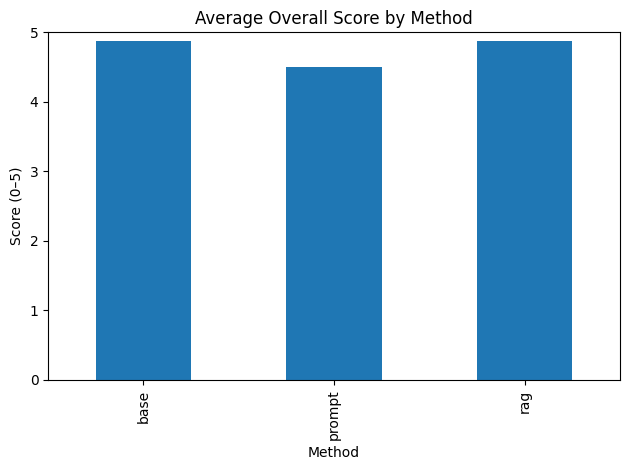

Saved detailed results to ./eval_results.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def ensure_overall_columns(df: pd.DataFrame, prefix: str, metrics: List[str]) -> None:
    """Ensure there is an `{prefix}_overall` column; if missing, compute as mean of metrics."""
    overall_col = f"{prefix}_overall"
    if overall_col not in df.columns:
        missing = [f"{prefix}_{m}" for m in metrics if f"{prefix}_{m}" not in df.columns]
        if missing:
            print(f"Cannot compute {overall_col}; missing metric columns:", missing)
        else:
            df[overall_col] = df[[f"{prefix}_{m}" for m in metrics]].mean(axis=1).round(2)

def pick_winner(row: pd.Series, methods=("base","prompt","rag")) -> str:
    """Returns the best method by highest overall; handle ties by joining names with '='."""
    scores = {m: row.get(f"{m}_overall", np.nan) for m in methods}
    if all(pd.isna(v) for v in scores.values()):
        return "NA"
    max_score = np.nanmax(list(scores.values()))
    winners = [m for m, v in scores.items() if np.isclose(v, max_score, equal_nan=False)]
    return "=".join(winners)

# ---- Main evaluation summary ----
METRICS = ["relevance","groundedness","completeness","specificity","safety"]
for pref in ("base","prompt","rag"):
    ensure_overall_columns(eval_df, prefix=pref, metrics=METRICS)

# Add winner per question
eval_df["best_method"] = eval_df.apply(pick_winner, axis=1)

# Summaries
winner_counts = eval_df["best_method"].value_counts().reset_index()
winner_counts.columns = ["best_method","count"]

method_means = pd.DataFrame({
    "metric": ["overall"],
    "base":   [eval_df["base_overall"].mean()],
    "prompt": [eval_df["prompt_overall"].mean()],
    "rag":    [eval_df["rag_overall"].mean()],
}).round(2)

# --- Show results ---
print("\n=== Per-question evaluation with winner ===")
print(eval_df[["idx","question","base_overall","prompt_overall","rag_overall","best_method"]])

print("\n=== Winner counts ===")
print(winner_counts)

print("\n=== Average overall by method ===")
print(method_means)

# --- Plot a simple bar chart ---
means = method_means[["base","prompt","rag"]].iloc[0]
plt.figure()
means.plot(kind="bar")
plt.title("Average Overall Score by Method")
plt.ylabel("Score (0–5)")
plt.xlabel("Method")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# --- Save CSV for downstream reporting ---
out_path = "./eval_results.csv"
eval_df.to_csv(out_path, index=False)
print(f"Saved detailed results to {out_path}")


## Actionable Insights and Business Recommendations

We observe that base-LLM, prompt-engineering LLM and RAG maintained pretty high scores across the board when compared on relevance, groundedness, completeness, specificity and safety. In fact, base-LLM performed nearly as well as RAG. It could be that the base-LLM's general knowledge aligns closely with the manual because sepsis protocols, appendicitis, TBI, etc. are widely known and embedded in training data. For that reason it could look just as grounded as RAG, even if in reality it was pulling from general knowledge.

Prompt-engineering encourages formatting/readability but doesn’t enforce citation. Also it received slightly lower scores.

RAG is the only method that guarantees grounding + citation.

**What we learned:**

- Readability: Prompt-engineering improves clarity → professionals prefer structured answers (time windows, bullet points, headings).

- Source citation: Only RAG can show where information comes from. This is critical in medicine (traceability, audit, clinical governance).

- Consistency: Base LLM may “do well now” but offers no guarantees it will cite or stay aligned with evolving protocols.

**Recommendations:**

1. Adopt RAG as default for production, because:

- It enforces alignment with your manual / guidelines, not just model’s memory.

- Provides traceability → essential for clinical audit, liability, and adoption.

- Easier to update → update the manual, re-embed, and your system reflects latest practice without waiting for a new model.

2. Layer prompt-engineering on top of RAG:

- Standardize format (e.g., “0–1h, 1–6h, 6–24h steps”).

- Require citations inline → builds trust with professionals.

- Add disclaimers (“general guidance, not individualized advice”).

Future features to consider:
Add more sources (local hospital protocols, WHO, specialty guidelines).

Add a feedback loop: Allow clinicians to flag “unclear” or “missing” answers; feed that into prompt-engineering refinements.

Resource management (rate limits, quatas, runtime, etc.) was the most challenging thing during this project. Therefore, resource allocation should be considered and managed ahead of time.
